# Bright Block Data Processing Notebook


## Functions used for checking + testing data

In [147]:
%reset 
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from math import radians, cos, sin, sqrt, atan2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def change_time_zone(uncorrected_time_zone_list, TimeZoneAdjustHours, yearsAdjustment):
    corrected_time_zone_list = []

    for timestamp in uncorrected_time_zone_list:
        # Parse the timestamp into a datetime object
        dt = datetime.strptime(timestamp, '%H:%M:%S %d/%m/%Y')
        # print(dt)

        # Adjust the time zone
        adjusted_dt = dt + timedelta(hours=TimeZoneAdjustHours)
        
        # Adjust the year
        adjusted_dt = adjusted_dt.replace(year=adjusted_dt.year + yearsAdjustment)

        # Convert back to the string format and add to the list
        corrected_time_zone_list.append(adjusted_dt.strftime('%H:%M:%S %d/%m/%Y'))

    return corrected_time_zone_list

def count_row_duplicates(df):
    # Create a temporary DataFrame indicating duplicated rows
    temp_df = df.copy()
    temp_df['IsDuplicated'] = df.duplicated(keep=False)

    # Group by all columns (excluding the 'IsDuplicated' column) and count duplicates
    duplicate_counts = temp_df.groupby(list(df.columns))['IsDuplicated'].sum()

    return duplicate_counts.reset_index(name='DuplicationCount').sort_values(by='TimeStamp', ascending=True)


def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance in kilometers between two points on the Earth."""
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def calculate_velocity(df, rolling_sample):
    # Ensure the DataFrame is sorted by time
    df['TimeStampAdjusted'] = pd.to_datetime(df['TimeStampAdjusted'], format='%H:%M:%S %d/%m/%Y')
    df = df.sort_values('TimeStampAdjusted')

    # Calculate the distance and time difference
    df['lat_shifted'] = df['Latitude'].shift()
    df['lon_shifted'] = df['Longitude'].shift()
    df['time_shifted'] = df['TimeStampAdjusted'].shift()

    df['dist'] = df.apply(lambda row: haversine(row['lat_shifted'], row['lon_shifted'], row['Latitude'], row['Longitude']) if pd.notnull(row['lat_shifted']) else 0, axis=1)
    df['time_diff'] = (df['TimeStampAdjusted'] - df['time_shifted']).dt.total_seconds() / 3600

    # Apply rolling sample
    df['rolling_dist'] = df['dist'].rolling(window=rolling_sample, min_periods=1).sum()
    df['rolling_time'] = df['time_diff'].rolling(window=rolling_sample, min_periods=1).sum()

    # Calculate velocity (km/h)
    df['velocity_km_h'] = df['rolling_dist'] / df['rolling_time']
    df['velocity_km_h'] = df['velocity_km_h'].replace([np.inf, -np.inf], 0)  # Handle division by zero
    df['velocity_m_h'] = df['velocity_km_h'] * 0.621371 
    
    # Round the velocities to 4 decimal places
    df['velocity_km_h'] = df['velocity_km_h'].round(4)
    df['velocity_m_h'] = df['velocity_m_h'].round(4)

    return df.drop(['lat_shifted', 'lon_shifted', 'time_shifted', 'dist', 'time_diff', 'rolling_dist', 'rolling_time'], axis=1)

def makeLeaflet(df, dataType, autoName, autoThreshold: bool, highThreshold = 50, lowThreshold = 0):
    import folium
    from branca.colormap import LinearColormap
    from branca.element import Figure
    from folium import IFrame, Marker

    centralLatitude = df.Latitude.mean()
    centralLongitude = df.Longitude.mean()
    leftLongitude = df.Longitude.min()
    rightLongitude =  df.Longitude.max()
    longitudeSpan = rightLongitude - leftLongitude
    topLatitude = df.Latitude.max()
    bottomLatitude = df.Latitude.min()
    latitudeSpan = topLatitude - bottomLatitude

    if autoThreshold == True:
        highThreshold = df[dataType].max()
        lowThreshold = 0

    colors = ["green", "yellow", "red"]

    # Create a Folium map
    colormap = LinearColormap(colors, vmin=lowThreshold, vmax=highThreshold)
    m = folium.Map(location=[centralLatitude, centralLongitude],tiles="Cartodb Positron", zoom_start=14)
    colormap.caption = dataType 

    # Prepare data for the line
    line_data = [(row['Latitude'], row['Longitude']) for index, row in df.iterrows()]

    # Normalize data values and get colors
    normColorData = [colormap(min(max(row[dataType], lowThreshold), highThreshold)) for index, row in df.iterrows()]

    # Plot the line
    for i in range(len(line_data)-1):
        folium.PolyLine(line_data[i:i+2], color=normColorData[i], weight=5).add_to(m)
        
        
    markers = df[(df['ButtonPress'] != 0)].reset_index()
    for i in range(len(markers)):
        folium.CircleMarker(location=[markers.Latitude[i] , markers.Longitude[i]], color = 'black', icon_color= 'red', radius=3, fill=True).add_to(m)

    # Add the colormap to the map
    colormap.add_to(m)

    # Create a Figure and add the map to it (for better control)
    fig = Figure(width=800, height=500)
    fig.add_child(m)

    # Add the title HTML to the Folium map
    Marker(location=[centralLatitude + latitudeSpan/2, centralLongitude - longitudeSpan/3], icon=folium.DivIcon(html=f"""
                <div style="
                    background-color: white; 
                    border: 1px solid black;
                    padding: 10px;
                    font-family: arial; 
                    color: black;
                    text-align: center;
                    white-space: nowrap; /* Prevents text wrapping */
                    width: auto; /* Adjust width as needed */
                    display: inline-block; /* Ensure background covers text */
                    ">
                    {autoName}
                </div>
                """)
    ).add_to(m)

    # Display the map
    return m


def plotTimeSeriesData(data, dataType1, dataType2=None, title=None, yAxisSame = None):
    # Create a new figure and a subplot
    fig, ax1 = plt.subplots()

    # Plotting data for the first data type
    color ='tab:blue'
    if dataType2:
        textColor ='tab:blue'
    else:
        textColor = 'black'

    ax1.set_xlabel('Time')
    ax1.set_ylabel(dataType1, color=textColor)
    ax1.plot(data['TimeStampHMS'], data[dataType1], color=color)
    ax1.tick_params(axis='y')

    # If a second data type is provided, create a twin axis and plot it
    if dataType2:
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel(dataType2, color=color)
        ax2.plot(data['TimeStampHMS'], data[dataType2], color=color)
        ax2.tick_params(axis='y')

    # Handle time axis
    start_time = data["TimeStampHMS"][data.index.min()] 
    end_time = data["TimeStampHMS"][data.index.max()] 
    plt.xticks(rotation=45)
    numDesiredTicks = 5.01  # Adjust as needed
    step_size = len(data['TimeStampHMS'])  / numDesiredTicks #557 Ticks 
    ax1.set_xticks(np.arange(0, len(data['TimeStampHMS']), step_size))
    ax1.set_xlim(start_time, end_time)

    if yAxisSame == True:
        # Calculate the global minimum and maximum
        global_min = min(data[dataType1].min(), data[dataType2].min())
        global_max = max(data[dataType1].max(), data[dataType2].max())

        # Set the same y-axis limits for both axes based on global min and max
        ax1.set_ylim(global_min, global_max)
        ax2.set_ylim(global_min, global_max)

    # Set the title if provided
    if title:
        plt.title(title)
    else:
        plt.title(dataType1 + (" & " + dataType2 if dataType2 else "") + " vs Time")

    fig.tight_layout()
    plt.show()

def plotCorrelationData(data, dataType1, dataType2, title):
    color = 'tab:blue'
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(dataType1)
    ax1.set_ylabel(dataType2)
    ax1.plot(data[dataType1], data[dataType2], '.',color=color, label = dataType1 + " vs " + dataType2)

    # ax1.plot( [data[dataType1].min(), data[dataType1].max()], [bestFit0, bestFitEnd],color='black', label ="Best Fit Line")
    ax1.tick_params(axis='y')
    ax1.legend()
    plt.title(title)
    fig.tight_layout()
    plt.show()

    import pandas as pd

def export_dataframe_to_csv(dataframe, file_path, index=False):
    # Use the to_csv method to export the DataFrame
    dataframe.to_csv(file_path, index=index)
    print(f"DataFrame has been exported to {file_path}")


def processToSummaryData(folder_path):
    import pandas as pd
    import numpy as np

    file_names = os.listdir(folder_path)

    metrics_summary = pd.DataFrame()  # Initialize an empty DataFrame for the summary of metrics
    for file_name in file_names:
        if file_name.startswith("Event") and file_name.endswith(".txt"):
            try:
                file_path = os.path.join(folder_path, file_name)
                FileNo = file_name.split('Event')[1].split('.txt')[0]  # Extract the event number from the file name
                
                # Attempt to read the data file
                data = pd.read_csv(file_path, header=0)
                print(FileNo)
                #Screening for GPS Data 
                data = data[(data['Latitude'] != 0) | (data['Longitude'] != 0)]
                data = count_row_duplicates(data)
                averageDuplication = np.mean(data.DuplicationCount)

                # Adjust timestamp
                TimeZoneAdjust = -8
                yearsAdjustment = 2000

                # need to change this in order to process the funky timezones as they come up
                data["TimeStampAdjusted"] = change_time_zone(data.TimeStamp, TimeZoneAdjust, yearsAdjustment) 
                data["TimeStampHMS"] = data["TimeStampAdjusted"].str[0:8]

                startTime = data["TimeStampAdjusted"][data.index.min()]

                formatted_date = startTime[12:15] + startTime[9:11] + " " +startTime[0:5];  # '09:22:26 04/12/0023'
                autoName = 'E' + FileNo + ": " +  formatted_date   

                rollingAveraging = 20
                data = calculate_velocity(data, rollingAveraging)
                data = data.replace(np.nan, 0)

                new_row = pd.DataFrame({
                    'FileNo': [file_name],
                    'DateTime': [autoName],
                    'NumUniqueDataPoints': [len(data['PressurehPa'])],
                    'MaxValuePM25': [data['PM25'].max()],
                    'StandardDevPM25': [data['PM25'].std()],
                    'CorrelationCoeff_VelPM25': np.corrcoef(data['velocity_m_h'], data['PM25'])[0, 1],
                    'CorrelationCoeff_RelHumidPM25': np.corrcoef(data['RelativeHumidity'], data['PM25'])[0, 1],
                    'CorrelationCoeff_TempPM25': np.corrcoef(data['Temperature'], data['PM25'])[0, 1],
                    'AveragePressure': np.mean(data['PressurehPa']),
                    'STDPressure': np.std(data['PressurehPa']),
                    'MinAltitude': np.min(data['Altitude']),
                    'MaxAltitude': np.max(data['Altitude']),
                    'AverageSpeed': np.mean(data['velocity_m_h']),
                    'StdSpeed': np.std(data['velocity_m_h']),
                    # 'PressureErrorTerm': sum((data['PressurehPa']**2 - data['PressurehPa'][0]**2)) / len(data['PressurehPa']),
                })
                
                metrics_summary = pd.concat([metrics_summary, new_row], ignore_index=True)

            except Exception as e:
                print(f"Error processing file {file_name}: {str(e)}")

    return metrics_summary

def processToDataLake(folder_path):
    import pandas as pd
    import numpy as np

    file_names = os.listdir(folder_path)

    outputFrame = pd.DataFrame()  # Initialize an empty DataFrame for the summary of metrics
    for file_name in file_names:
        if file_name.startswith("Event") and file_name.endswith(".txt"):
            try:
                
                file_path = os.path.join(folder_path, file_name)
                FileNo = file_name.split('Event')[1].split('.txt')[0]  # Extract the event number from the file name
                
                # Attempt to read the data file
                data = pd.read_csv(file_path, header=0)
                # print(FileNo)
                data["Event"] = FileNo            
            
                #Screening for GPS Data 
                data = data[(data['Latitude'] != 0) | (data['Longitude'] != 0)]
                data = count_row_duplicates(data)
                averageDuplication = np.mean(data.DuplicationCount)

                # Adjust timestamp
                TimeZoneAdjust = -8
                yearsAdjustment = 2000

                # need to change this in order to process the funky timezones as they come up
                data["TimeStampAdjusted"] = change_time_zone(data.TimeStamp, TimeZoneAdjust, yearsAdjustment) 
                data["TimeStampHMS"] = data["TimeStampAdjusted"].str[0:8]
                data["TimeStamp"] = data["TimeStampAdjusted"]

                startTime = data["TimeStampAdjusted"][data.index.min()]

                formatted_date = startTime[12:15] + startTime[9:11] + " " +startTime[0:5];  # '09:22:26 04/12/0023'
                autoName = 'E' + FileNo + ": " +  formatted_date   

                rollingAveraging = 20
                data = calculate_velocity(data, rollingAveraging)
                data = data.replace(np.nan, 0)
                outputFrame = pd.concat([outputFrame, data], ignore_index=True)

            except Exception as e:
                print(f"Error processing file {file_name}: {str(e)}")
    return outputFrame


In [153]:
dataLakePath = "RawData/DataLake"
dataLake = processToDataLake(dataLakePath)
dataLakeStorePath = "RawData/DataLake/dataLake.csv"
export_dataframe_to_csv(dataLake, dataLakeStorePath,  index=False)


DataFrame has been exported to RawData/DataLake/dataLake.csv


In [130]:
folder_path = 'RawData'
summary_metrics = processToSummaryData(folder_path)

['Event48.txt', 'Event61.txt', 'Event77.txt', 'Event88.txt', 'Event89.txt', 'Event76.txt', 'Event66.txt', 'Event72.txt', '.DS_Store', 'Event67.txt', 'Event71.txt', 'Event65.txt', 'NO GPS DATA', 'Event58.txt', 'Event64.txt', 'Event70.txt', 'EventCombined.txt', 'Event29.txt', 'Event36.txt', 'Event37.txt', 'No edit for GPS', 'Event20.txt', 'Event30.txt', 'Event25.txt', 'Event69.txt', 'Event96.txt', 'Event82.txt', 'Event83.txt', 'Event97.txt', 'Event68.txt', 'Event81.txt', 'Event95.txt', 'Event94.txt', 'Event80.txt', 'Event57.txt', 'Event43.txt', 'Event47.txt', 'Event53.txt', 'Event90.txt', 'Event91.txt', 'Event85.txt', 'Event46.txt', 'Event50.txt', 'Event44.txt', 'Event78.txt', 'Event93.txt', 'Event87.txt', 'Event86.txt', 'Event92.txt', 'Event79.txt', 'Event51.txt']


In [140]:
filePathTimeAdjusted = 'ProcessedData/Event' + FileNo +'.csv' 
dataSave["TimeStamp"] = dataSave["TimeStampAdjusted"]
export_dataframe_to_csv(data, filePathTimeAdjusted, index=False)

NameError: name 'FileNo' is not defined

In [119]:
FileNo = '71' 

In [120]:
file_path = 'RawData/Event' + FileNo + '.txt'
data = pd.read_csv(file_path, header=0)


#Screening for GPS Data 
data = data[(data['Latitude'] != 0) | (data['Longitude'] != 0)]
data = count_row_duplicates(data)
averageDuplication = np.mean(data.DuplicationCount)

# Adjust timestamp
TimeZoneAdjust = -8
yearsAdjustment = 2000

# need to change this in order to process the funky timezones as they come up
data["TimeStampAdjusted"] = change_time_zone(data.TimeStamp, TimeZoneAdjust, yearsAdjustment) 
data["TimeStampHMS"] = data["TimeStampAdjusted"].str[0:8]

startTime = data["TimeStampAdjusted"][data.index.min()]

formatted_date = startTime[12:15] + startTime[9:11] + " " +startTime[0:5];  # '09:22:26 04/12/0023'
autoName = 'E' + FileNo + ": " +  formatted_date   
Pressure_STD = np.std(data["PressurehPa" ])
Pressure_Mean = np.mean(data["PressurehPa" ])


MinAlt = np.min(data["Altitude"])
MaxAlt = np.max(data["Altitude"])

initial_pressure = data["PressurehPa"][0]
pressureDelta = sum((data["PressurehPa"]**2 - initial_pressure**2))
pressureDeltaNormalized = pressureDelta/len(data["PressurehPa"])

rollingAveraging = 20
data = calculate_velocity(data, rollingAveraging)
data = data.replace(np.nan, 0)

dataType1 = "velocity_m_h" 
dataType2 = "PressurehPa" 
correlation_Velocity = np.corrcoef([data["velocity_m_h"], data["PM25"]])
bestFit = np.polyfit(data[dataType1], data[dataType2],1)
bestFit0 = bestFit[1] + data[dataType1].min() * bestFit[0]
bestFitEnd = bestFit[1] + data[dataType1].max() * bestFit[0]

print("Processing:", autoName)
print("MaxValue PM25 " + '{:.2f}'.format(data.PM25.max()))
print("Standard Dev PM25 " + '{:.2f}'.format(data.PM25.std()))
print("Correlation Coeff: " + '{:.2f}'.format(correlationP[0,1]))

print("Num Unique Data Points: " + '{:d}'.format(len(data["PressurehPa"])))
print("Average Pressure: " + '{:.2f}'.format(Pressure_Mean))
print("STD Pressure: " + '{:.3f}'.format(Pressure_STD))
print("Min Altitude [m] : " + '{:.2f}'.format(MinAlt))
print("Max Altitude [m]: " + '{:.2f}'.format(MaxAlt))
print("Average Speed: " + '{:.2f}'.format(data.velocity_m_h.mean()))
print("Std Speed: " + '{:.2f}'.format(np.std(data.velocity_m_h)))
print("Pressure Error Term: " + '{:.5f}'.format(pressureDeltaNormalized))
print("Average Duplication: " + '{:.2f}'.format(averageDuplication))

Processing: E71: 01/20 09:26
MaxValue PM25 7.30
Standard Dev PM25 0.89
Num Unique Data Points: 63
Average Pressure: 1005.03
STD Pressure: 0.651
Min Altitude [m] : 29.50
Max Altitude [m]: 151.10
Average Speed: 17.44
Std Speed: 3.95
Correlation Coeff: -0.58
Pressure Error Term: 1461.17302
Average Duplication: 2.00


In [599]:
filePathTimeAdjusted = 'ProcessedData/Event' + FileNo +'.csv' 
dataSave = data
dataSave["TimeStamp"] = dataSave["TimeStampAdjusted"]
export_dataframe_to_csv(data, filePathTimeAdjusted, index=False)

DataFrame has been exported to ProcessedData/Event96.csv


## [1] Plotting the physical PM2.5 Map 


In [121]:
# lap1 = [351:450]
mapObject = makeLeaflet(data,"PM25",autoName, True)
mapObject

In [426]:

mapObject = makeLeaflet(data,"Altitude",autoName, autoThreshold = False,  highThreshold= np.max(data['Altitude']), lowThreshold = np.min(data["Altitude"]) )
mapObject

In [427]:
mapObject = makeLeaflet(data,"PressurehPa",autoName, autoThreshold = False,  highThreshold= np.max(data['PressurehPa']), lowThreshold = np.min(data["PressurehPa"]) )
mapObject


In [272]:
mapObject = makeLeaflet(data,"vocIndex",autoName, True)
mapObject

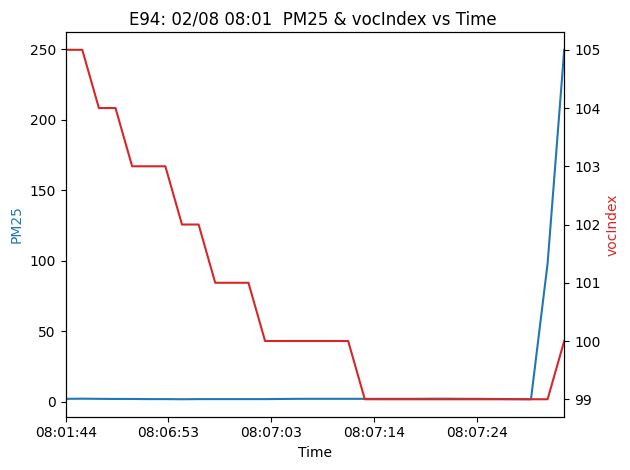

In [12]:
# PM2.5 and Voc triangle (temporal error)
dataType1 = "PM25"
dataType2 = "vocIndex"
title_pm2Voc = autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time "
plotTimeSeriesData(data, dataType1=dataType1,dataType2=dataType2, title=title_pm2Voc )


## [2] Pressure vs Time Graph

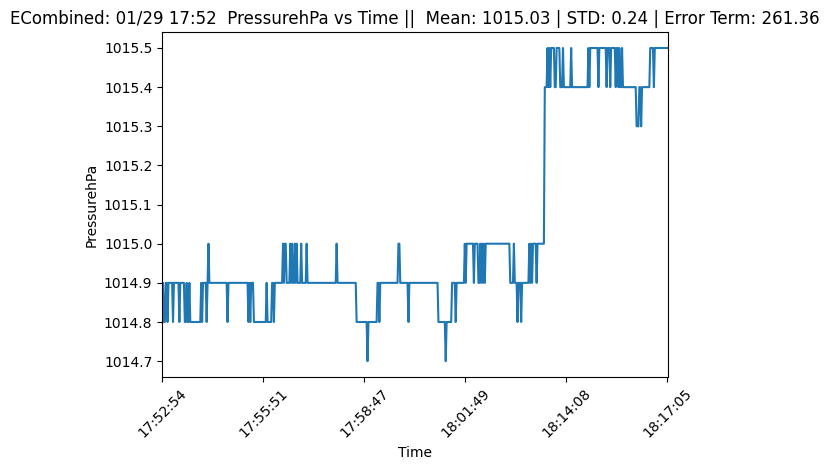

In [529]:
dataType = "PressurehPa" 
initial_pressure = data[dataType][0]
pressureDelta = sum((data[dataType]**2 - initial_pressure**2))
pressureDeltaNormalized = pressureDelta/len(data[dataType])
title= autoName + "  " + dataType + " vs Time ||  Mean: " + '{:.2f}'.format(Pressure_Mean) + " | STD: " + '{:.2f}'.format(Pressure_STD) + " | Error Term: " + '{:.2f}'.format(pressureDeltaNormalized)

plotTimeSeriesData(data, dataType1=dataType, title=title )


In [530]:
dataType = "PressurehPa" 
initial_pressure = data[dataType][0]
pressureDelta = sum((data[dataType]**2 - initial_pressure**2))
pressureDeltaNormalized = pressureDelta/len(data[dataType])
title = autoName + "  " + dataType + " vs Time ||  Mean: " + '{:.2f}'.format(Pressure_Mean) + " | STD: " + '{:.2f}'.format(Pressure_STD) + " | Error Term: " + '{:.2f}'.format(pressureDeltaNormalized)
yAxisSame = False



##  3. Presssure vs speed graph

### Leaflet 

In [572]:
mapObject = makeLeaflet(data,"velocity_m_h",autoName, True)
mapObject

### Plotting Speed and Pressure vs Time

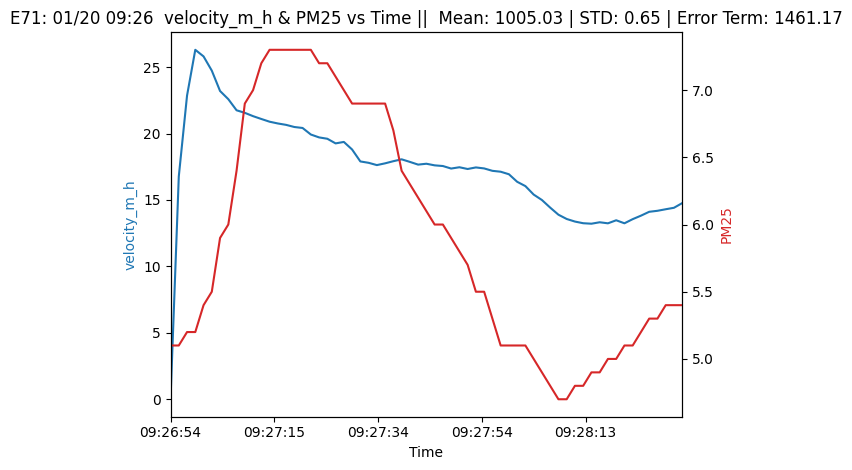

In [122]:
dataType1 = "velocity_m_h" 
dataType2 = "PM25" 
title = autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time ||  Mean: " + '{:.2f}'.format(Pressure_Mean) + " | STD: " + '{:.2f}'.format(Pressure_STD) + " | Error Term: " + '{:.2f}'.format(pressureDeltaNormalized)

plotTimeSeriesData(data, dataType1=dataType1, dataType2=dataType2, title=title)

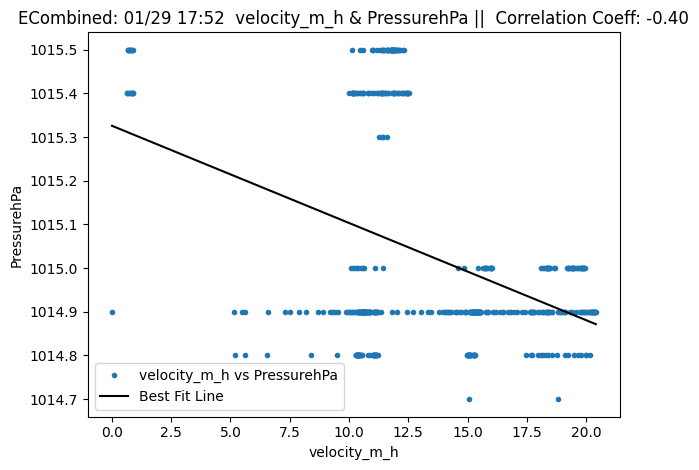

In [347]:

# Correlation Data plot!
dataType1 = "velocity_m_h" 
dataType2 = "PressurehPa" 
title = autoName + "  "+ dataType1 + " & " + dataType2 + " ||  Correlation Coeff: " + '{:.2f}'.format(correlationP[1,0])

plotCorrelationData(data, dataType1=dataType1, dataType2=dataType2, title=title)


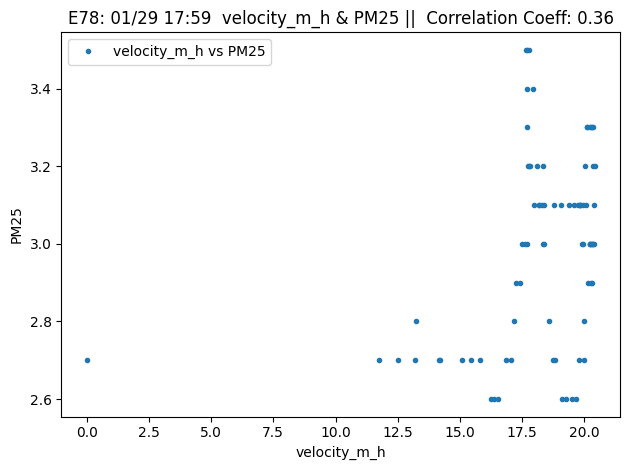

In [72]:

# Correlation Data plot!
dataType1 = "velocity_m_h" 
dataType2 = "PM25" 
correlationP = np.corrcoef([data[dataType1], data[dataType2]])
title = autoName + "  "+ dataType1 + " & " + dataType2 + " ||  Correlation Coeff: " + '{:.2f}'.format(correlationP[1,0])

plotCorrelationData(data, dataType1=dataType1, dataType2=dataType2, title=title)

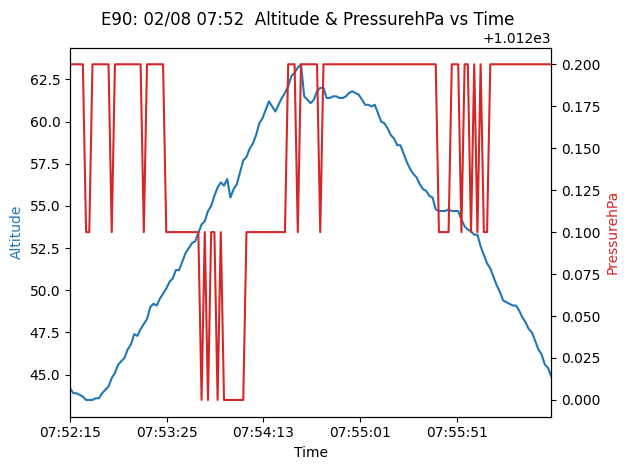

In [563]:
dataType1 = "Altitude" 
dataType2 = "PressurehPa" 

title = autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time "
plotTimeSeriesData(data, dataType1=dataType1, dataType2=dataType2, title=title)


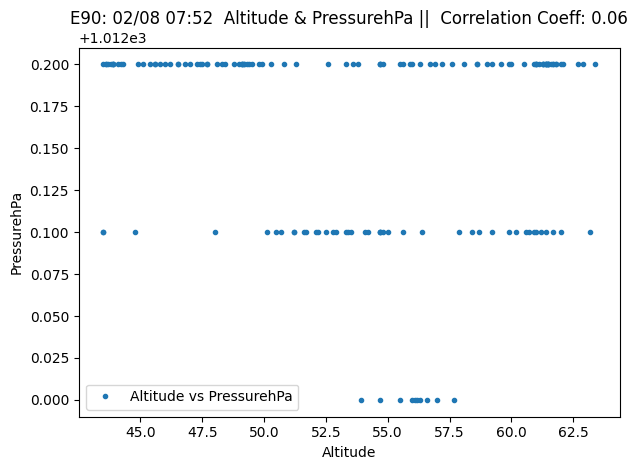

In [564]:

dataType1 = "Altitude" 
dataType2 = "PressurehPa" 
title = autoName + "  "+ dataType1 + " & " + dataType2 + " ||  Correlation Coeff: " + '{:.2f}'.format(correlationP[1,0])

plotCorrelationData(data, dataType1=dataType1, dataType2=dataType2, title=title)

## [Other] Duplication Debug Code 

Two Plots showing Duplication in the dataset

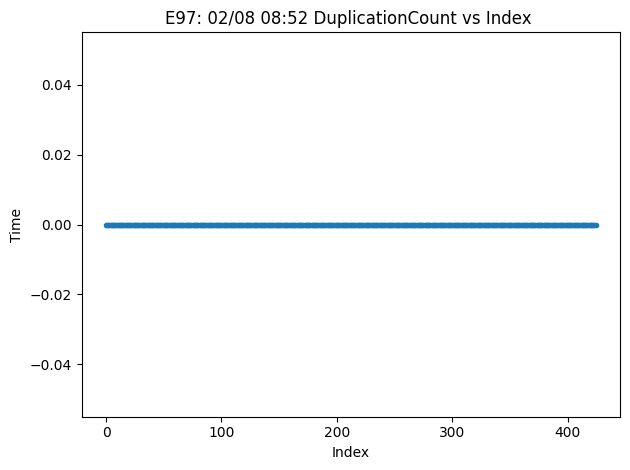

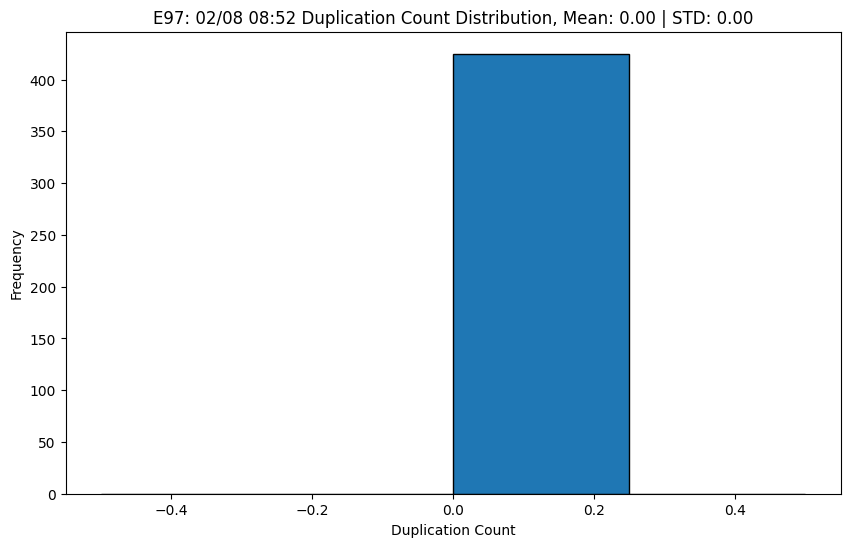

In [418]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Time')
ax1.plot(data['DuplicationCount'],'.' , color=color)
ax1.tick_params(axis='y')

startTime = data["TimeStampAdjusted"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampAdjusted"][final_Index]

count_ticks = 10
plt.title(autoName + " DuplicationCount vs Index ")

# Show the plot
fig.tight_layout()
plt.show()

# Create a new figure for the histogram
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(data['DuplicationCount'], bins=4, color='tab:blue', edgecolor='black')

Duplication_STD = np.std(data['DuplicationCount'])
Duplication_Mean = np.mean(data['DuplicationCount'])

# Set the title and labels
plt.title(autoName + " Duplication Count Distribution, Mean: " + '{:.2f}'.format(Duplication_Mean) + " | STD: " + '{:.2f}'.format(Duplication_STD) )
plt.xlabel('Duplication Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## Figureing out what is going on with pressure:

Calculated pressure from GPS values but those are not a good estimate ( go negative ect )

In [281]:
import pandas as pd
import numpy as np

def correct_pressure(df, altitude_column):
    # Constants
    P0 = 1013.25  # Sea level standard atmospheric pressure in hPa
    L = 0.0065    # Standard temperature lapse rate in K/m
    T0 = 288.15   # Standard temperature at sea level in K
    g = 9.80665   # Acceleration due to gravity in m/s²
    M = 0.0289644 # Molar mass of Earth's air in kg/mol
    R = 8.3144598 # Universal gas constant in J/(mol·K)

    # Corrected Pressure Calculation
    df['correctedPressurehPa'] = P0 * (1 - (L * df[altitude_column]) / T0) ** (g * M / (R * L))

    return df

# Usage example
df = data
df = correct_pressure(df, 'Altitude')



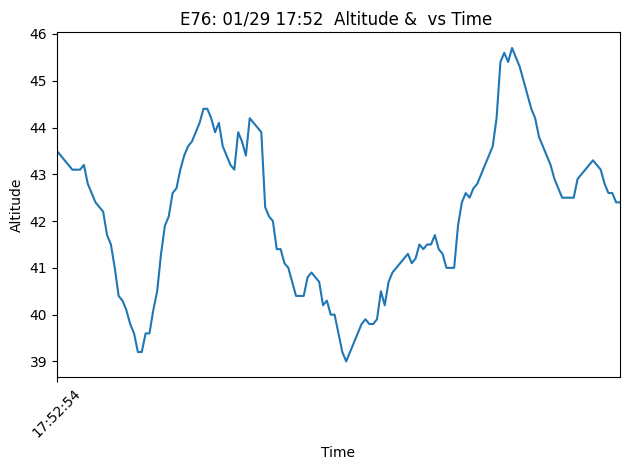

In [282]:
dataType1 = "Altitude" 
# dataType2 = "PressurehPa" 

title = autoName + "  "+ dataType1 + " & " + " vs Time "
plotTimeSeriesData(data, dataType1=dataType1, title=title)

In [283]:
import requests

# def get_altitude(latitude, longitude):
#     # Open Elevation API endpoint
#     url = "https://api.open-elevation.com/api/v1/lookup"

#     # Parameters for the API request
#     params = {
#         "locations": f"{latitude},{longitude}"
#     }

#     # Making the request to the API
#     response = requests.get(url, params=params)

#     if response.status_code == 200:
#         data = response.json()
#         # Extract the altitude from the response
#         # The structure is {'results': [{'elevation': altitude, 'latitude': lat, 'longitude': lon}]}
#         if data["results"]:
#             altitude = data["results"][0]["elevation"]
#             return altitude
#         else:
#             print("No elevation data found for the given coordinates.")
#             return None
#     else:
#         print(f"Error fetching data: {response.status_code}")
#         return None

# Example usage
# Replace with actual coordinates
    

# def lookupAltitude(df):
# Define a lambda function that applies get_altitude to each row
df['lookedUpAltitude'] = df.apply(lambda row: get_altitude(row['Latitude'], row['Longitude']), axis=1)
    # return df
# newDf = lookupAltitude(df)


NameError: name 'get_altitude' is not defined

KeyError: 'lookedUpAltitude'

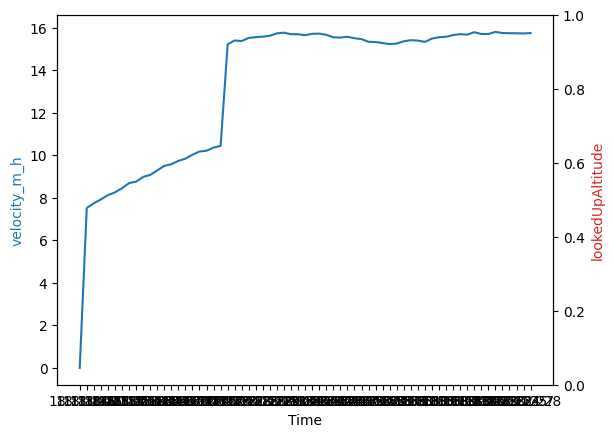

In [ ]:
dataType1 = "velocity_m_h"   
dataType2 = "lookedUpAltitude" 
 
title = autoName + "  "+ dataType1 + " & " + dataType2 + " vs Time "
plotTimeSeriesData(df, dataType1=dataType1, dataType2=dataType2, title=title, yAxisSame=False)

In [ ]:

# type(df["lookedUpAltitude"])
# colormap(min(max(row[dataType], lowThreshold), highThreshold)) for index, row in df.iterrows()]
# mapObject = makeLeaflet(df,"lookedUpAltitude",autoName, True)
# mapObject

numpy.float64

In [ ]:
# def get_altitude(latitude, longitude):
    # Open Elevation API endpoint

latitude = df["Latitude"][1]
longitude = df["Longitude"][1]

url = "https://api.open-elevation.com/api/v1/lookup"

# Parameters for the API request
params = {
    "locations": f"{latitude},{longitude}"
}

# Making the request to the API
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    # Extract the altitude from the response
    # The structure is {'results': [{'elevation': altitude, 'latitude': lat, 'longitude': lon}]}
    if data["results"]:
        print(data["results"])
        altitude = data["results"][0]["elevation"]
    else:
        print("No elevation data found for the given coordinates.")
else:
    print(f"Error fetching data: {response.status_code}")


[{'latitude': 37.733074, 'longitude': -122.42841, 'elevation': 40.0}]
